### 1. 基础版本的MOE

输入是一个 Token, 输出是一个 Token Embedding。暂时先不考虑 MOE 得到的 Embedding 怎么使用。

因为 MOE 网络对应着 Expert，这个 Expert 一般是一个 FeadFoward Network，FFN。而为了简化，后续我们都用一层的 Linear 代替。下面是一个专家的定义。

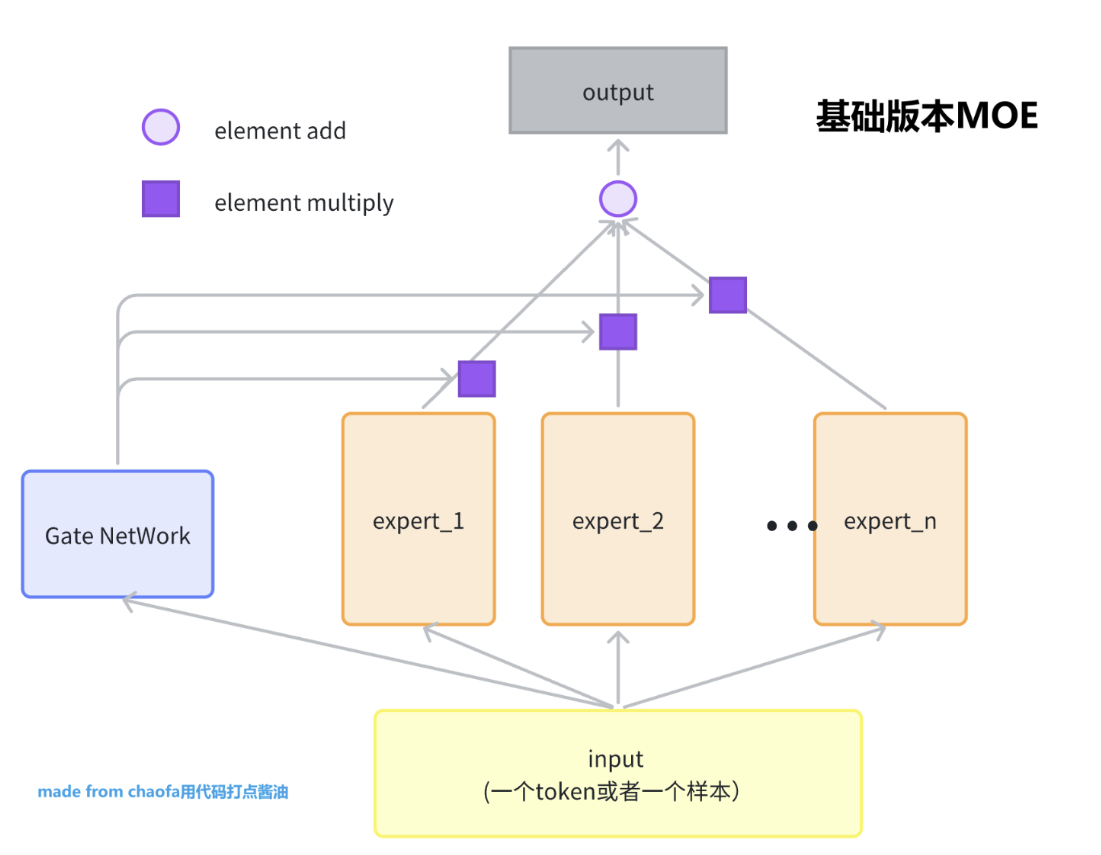

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from dataclasses import dataclass

In [3]:
class BasicExpert(nn.Module):
    # 一个 Expert 可以是一个最简单的， linear 层即可
    # 也可以是 MLP 层
    # 也可以是 更复杂的 MLP 层（active function 设置为 swiglu）
    def __init__(self, feature_in, feature_out):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(feature_in, 4 * feature_in),
            nn.GELU(),
            nn.Linear(4 * feature_in, feature_out),
            nn.Dropout(0.1)
        )
    
    def forward(self, x):
        return self.ffn(x) 

In [4]:
class BasicMOE(nn.Module):
    def __init__(self, feature_in, feature_out, num_experts):
        super().__init__()
        # gate output shape (batch_size, num_experts)
        self.gate = nn.Linear(feature_in, num_experts)
        self.experts = nn.ModuleList(
            [
                BasicExpert(
                    feature_in, feature_out
                    ) for _ in range(num_experts)
            ]
        )

    def forward(self, x):
        # x shape: (batch_size, feature_in)
        # feature_in 也是 hidden_dim/ hidden_size
        expert_weights = self.gate(x)   # (batch_size, num_experts)
        expert_out_list = [
            expert(x) for expert in self.experts
        ]   # 每一个 expert 都输出 (batch_size, feature_out)
        
        expert_outs = [
            expert_out.unsqueeze(1) 
            for expert_out in expert_out_list
        ]   # list 每一个元素的shape是 (batch_size, 1, feature_out)

        # 希望的 expert_output 是 (batch_size, num_experts, feature_out)
        expert_output = torch.concat(
            expert_outs,
            dim = 1
        )
        
        # expert_weight做softmax
        expert_weights = F.softmax(expert_weights, dim = -1)

        # 最后希望的输出是 (batch_size, feature)
        expert_weights = expert_weights.unsqueeze(1)    # shape (batch_size, 1, num_experts)
        output = expert_weights @ expert_output # (batch_size, 1, feature_out)
        return output.squeeze(1)

In [5]:
def test_basic_moe():
    x = torch.randn(4, 512)
    basic_moe = BasicMOE(512, 128, num_experts = 4)
    output = basic_moe(x)
    print(output.shape)

test_basic_moe()

torch.Size([4, 128])


### 2. SparseMOE, MOE LLM

和Basic的区别就是MOE选择topK个专家，然后对这topK个专家的输出进行加权求和，并把输入样本变成了大模型中真实的输入shape (batch_size, seq_len, hidden_dim)

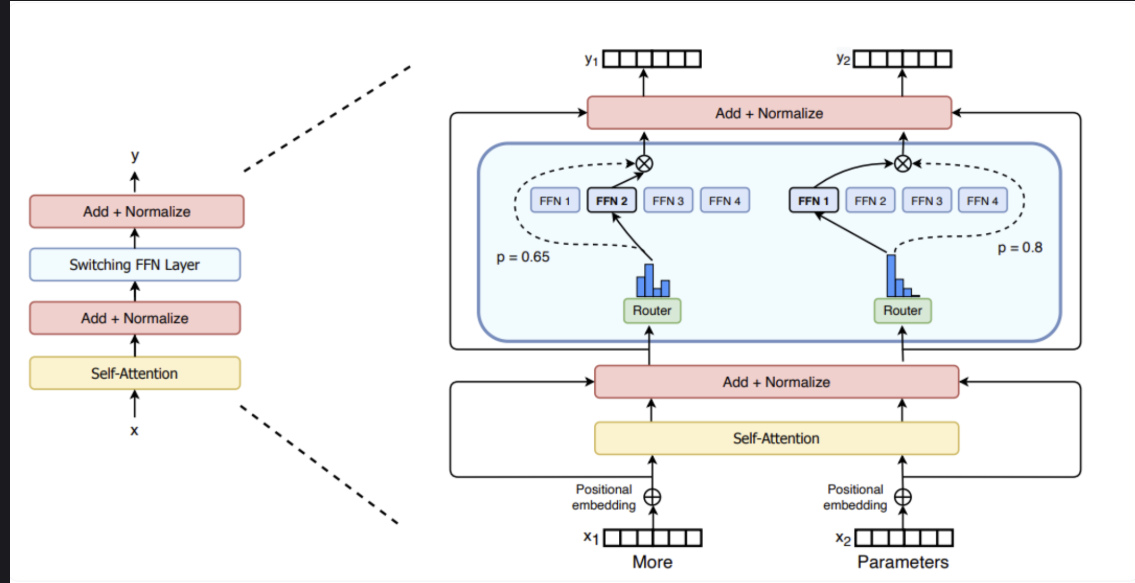

In [6]:
class MOEConfig:
    def __init__(self, 
                 hidden_dim, 
                 expert_number, 
                 top_k, 
                 shared_experts_numbers=2):
        self.hidden_dim = hidden_dim
        self.expert_number = expert_number
        self.top_k = top_k
        self.shared_experts_number = shared_experts_numbers

In [7]:
class MOERouter(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.gate = nn.Linear(config.hidden_dim, config.expert_number)
        # 后面只是选后面 topk个专家
        self.expert_number = config.expert_number
        self.top_k = config.top_k

    def forward(self, x):
        # 假设 expert_num = 8, top_k = 2
        router_logits = self.gate(x)   # (batch_size * seq_len, expert_number)

        # 计算每个专家的概率
        router_probs = F.softmax(router_logits, dim = -1, dtype = torch.float)

        # router_weights 的 ij 就是第 i 个 token 的 top_j 的专家的权重, 至于专家是哪个 indice 就是指出哪几个专家属于该token的topk
        # top_k 是可以反向传播的 
        router_weights, selected_experts_indices = torch.topk(
            router_probs,
            self.top_k,
            dim = -1
        )   # router_weight, selected_experts_indices 的shape都是 (batch_size * seq_len, top_k)

        # 再次softmax一下，重新归一化
        router_weights = router_weights / router_weights.sum(
            dim = -1, keepdim = True
        )           # (batch_size * seq_len, top_k)
        router_weights = router_weights.to(x.dtype)

        expert_mask = F.one_hot(
            selected_experts_indices,
            num_classes = self.expert_number,
        )   # 输出 (batch_size, * seq_len, top_k, expert_number)

        expert_mask = expert_mask.permute(2, 1, 0)  # 希望shape (expert_number, top_k, batch_size * seq_len)

        return router_logits, router_weights, selected_experts_indices, expert_mask
        
        
        # router_logits shape (batch_size * seq_len, expert_number)
        # router_weights shape (batch_size * seq_len, top_k)
        # selected_experts_indices shape (batch_size * seq_len, top_k)
        # expert_mask shape (expert_number, top_k, batch_size * seq_len)

In [8]:
a = F.one_hot(
        torch.tensor(torch.randint(low=1, high=5, size=(12,2)), dtype=torch.long),
        num_classes = 5,
        )   # 输出 (batch_size * seq_len, top_k, expert_number)
print(a.shape)  # (12, 2, 5)
print(a)

torch.Size([12, 2, 5])
tensor([[[0, 0, 1, 0, 0],
         [0, 0, 1, 0, 0]],

        [[0, 0, 1, 0, 0],
         [0, 0, 0, 0, 1]],

        [[0, 1, 0, 0, 0],
         [0, 0, 0, 0, 1]],

        [[0, 0, 1, 0, 0],
         [0, 0, 0, 0, 1]],

        [[0, 0, 0, 1, 0],
         [0, 0, 0, 0, 1]],

        [[0, 0, 0, 0, 1],
         [0, 0, 1, 0, 0]],

        [[0, 0, 0, 0, 1],
         [0, 0, 0, 0, 1]],

        [[0, 0, 1, 0, 0],
         [0, 0, 1, 0, 0]],

        [[0, 0, 0, 1, 0],
         [0, 0, 0, 0, 1]],

        [[0, 1, 0, 0, 0],
         [0, 1, 0, 0, 0]],

        [[0, 0, 0, 1, 0],
         [0, 0, 0, 1, 0]],

        [[0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0]]])


C:\Users\xqy16\AppData\Local\Temp\ipykernel_107604\1471878012.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(torch.randint(low=1, high=5, size=(12,2)), dtype=torch.long),


In [9]:
b = a.permute(2, 1, 0)  # (5, 2, 12)
print(b[4].shape)
print(b[4])
idx, top_x = torch.where(
                b[4]
            )
print(idx, top_x)

torch.Size([2, 12])
tensor([[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]])
tensor([0, 0, 1, 1, 1, 1, 1, 1]) tensor([5, 6, 1, 2, 3, 4, 6, 8])


In [10]:
router_w = torch.randn(12, 2)
print(router_w[top_x, idx].shape)
print(router_w[top_x, idx])

torch.Size([8])
tensor([ 0.8722, -1.0918, -1.0747, -0.8094,  0.9497, -0.1484,  1.5139, -1.0605])


In [11]:
class SparseMOE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.top_k = config.top_k
        self.hidden_dim = config.hidden_dim
        self.expert_number = config.expert_number

        # 初始化专家
        self.experts = nn.ModuleList(
            [
                BasicExpert(
                    config.hidden_dim,
                    config.hidden_dim
                )   for _ in range(config.expert_number)
            ]
        )
        self.router = MOERouter(config)

    def forward(self, x):
        # x shape (batch_size, seq_len, hidden_dim)
        
        batch_size, seq_len, hidden_dim = x.size()

        # token 维度计算, x reshape (batch_size * seq_len, hidden_dim)
        hidden_states = x.view(-1, hidden_dim)

        # 做相关专家计算
        router_logits, router_weights, selected_experts_indices, expert_masks = self.router(hidden_states)

        # expert_masks shape (expert_number, top_k, batch_size * seq_len)
        # 最终 final_hidden_states 是 (batch_size * seq_len, hidden_dim)
        final_hidden_states = torch.zeros(
            (batch_size * seq_len, hidden_dim),
            dtype = hidden_states.dtype,
            device = hidden_states.device
        )

        # 遍历专家，把选中该专家的token的hidden_states加入final_hidden_states中
        # 如 expert_0 可能有 100 个token选中了，token总数是batch * seq_len
        for expert_idx in range(self.expert_number):
            expert_layer = self.experts[expert_idx]

            # expert_masks (expert_num, top_k, batch_size * seq_len)
            # current_expert_mask (top_k, batch_size * seq_len)
            current_expert_mask = expert_masks[expert_idx]

            # top_idx 是 0 or 1 如果假设top_k=2，表示当前 token 是作为当前专家的top1 or top2
            # token_x 是 token 在 batch_size * seq_len 的索引位置, 如 b * s = 8，那么就是 0-7
            # top_idx 和 token_x 都是一个1维的值，有一个一一对应的关系！
            # top_idx为了选expert的哪个weight， token_x 是为了选 hidden_states （到底是哪个token）
            top_idx, token_x = torch.where(
                current_expert_mask
            )
            # hidden_states shape (batch_size * seq_len, hidden_dim)
            # unsqueeze的 shape (1, batch_size * seq_len, hidden_dim)

            # current_state shape (selected_token_number, hidden_dim)
            current_state = hidden_states.unsqueeze(0)[:, token_x, :].reshape(-1, hidden_dim)

            current_state = expert_layer(current_state)

            # current_token_router_weight shape (selected_token_number, )
            # token_x, top_idx 是两个长度相同的一维索引张量，PyTorch 会按位置一一对应提取元素，最终形成一个长度等于索引数量的一维张量。
            current_token_router_weight = router_weights[token_x, top_idx]
            # shape (selected_token_number, 1)
            # 虽然这里要知道哪个专家是该token的top_k要查indices，但其实已经得到了该专家的weight，具体是哪个专家就不需要在这一步搞了
            current_token_router_weight = current_token_router_weight.unsqueeze(-1)
            
            # current_state (selected_token_number, hidden_dim) 再* (selected_token_number, 1)广播
            current_hidden_states = current_state * current_token_router_weight

            # index_add_加下划线代表原地操作
            final_hidden_states.index_add_(
                dim = 0,    # 沿着哪个维度进行索引和累加
                index = token_x,  # 要累加token索引
                source = current_hidden_states.to(hidden_states.dtype),   # 提供累加值的源张量
            )
        # 把 final_hidden_states 还原
        final_hidden_states = final_hidden_states.reshape(batch_size, seq_len, hidden_dim)

        # router_logits shape (batch_size * seq_len, expert_number)，是为了算loss用的
        return final_hidden_states, router_logits   

In [12]:
def test_token_level_moe():
    x = torch.rand(2, 4, 16)
    config = MOEConfig(16, 2, 2)
    token_level_moe = SparseMOE(config)
    out, logits = token_level_moe(x)
    print(out[0].shape, out[1].shape)
    print(out)

test_token_level_moe()

torch.Size([4, 16]) torch.Size([4, 16])
tensor([[[ 0.1000, -0.2155,  0.1123,  0.1564,  0.0649, -0.0889, -0.1161,
          -0.0939, -0.1873,  0.0530,  0.0721, -0.0796,  0.0796,  0.0687,
          -0.0361, -0.0441],
         [ 0.2444, -0.1366,  0.0453,  0.1525, -0.0226, -0.1005,  0.0296,
          -0.0906, -0.1853, -0.0224,  0.1236, -0.0588,  0.0845,  0.0565,
           0.0020, -0.0014],
         [ 0.2203, -0.1173,  0.0941,  0.0949, -0.0102, -0.0104, -0.1387,
          -0.0983, -0.1192, -0.0051,  0.1151, -0.0456,  0.0817,  0.1455,
           0.0009, -0.0239],
         [ 0.1325, -0.1859,  0.0992,  0.1708,  0.0789,  0.0795, -0.1793,
          -0.1537, -0.2399,  0.0000,  0.1114, -0.0841,  0.0615,  0.1269,
           0.0501,  0.0082]],

        [[ 0.1049, -0.1646,  0.1333,  0.1643,  0.0838, -0.1083, -0.1570,
          -0.0400, -0.1864, -0.0567,  0.0637, -0.0530,  0.1339,  0.0361,
           0.0387,  0.0125],
         [-0.0536, -0.1790,  0.0705,  0.1190, -0.0544, -0.1072, -0.0583,
          

### 3. ShareExpert SparseMOE(deppseek)

主要区别在有一部分是常驻的专家

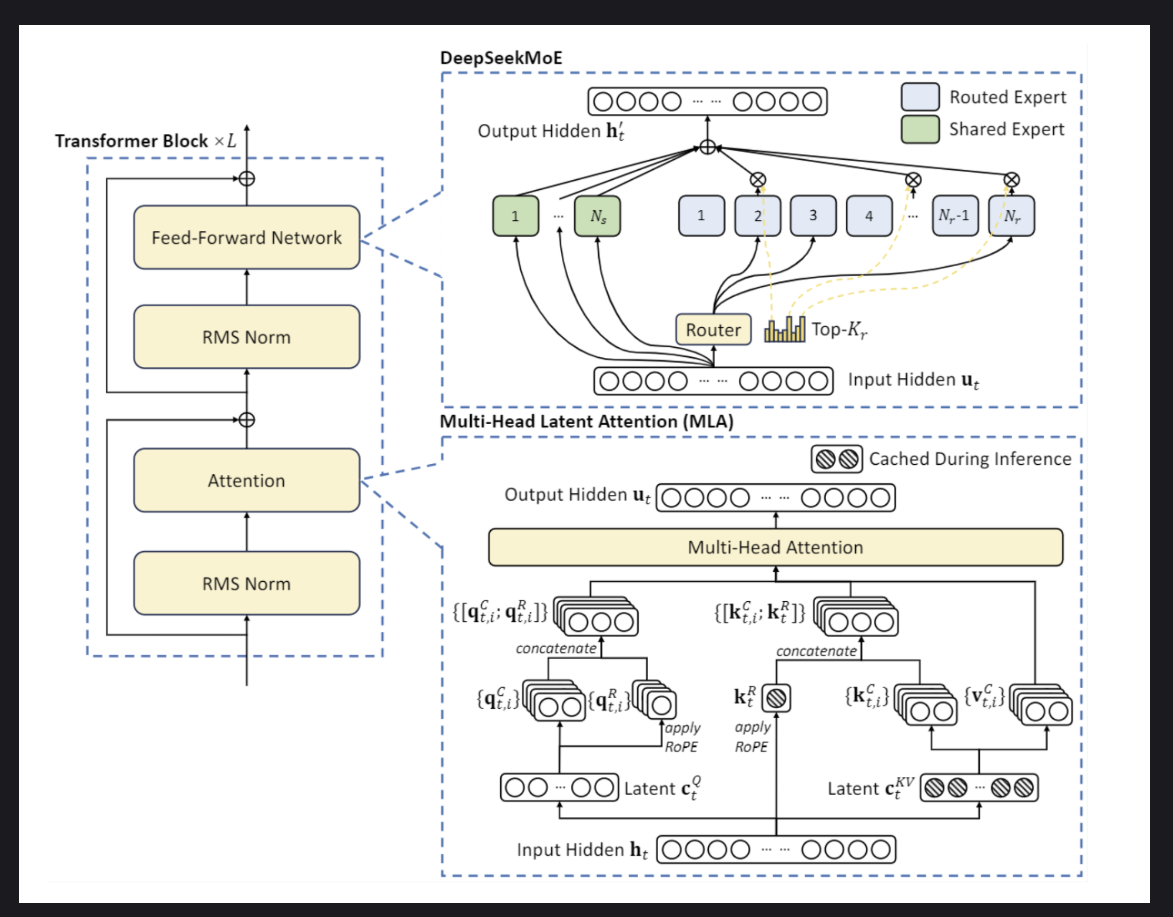

In [13]:
class SharedExpertMOE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.routed_experts_moe = SparseMOE(config)
        self.shared_experts = nn.ModuleList(
            [
                BasicExpert(self.config.hidden_dim, 
                            self.config.hidden_dim)
                        for _ in range(self.config.shared_experts_number)
            ]
        )

    def forward(self, x):
        # x shape (b, s, hidden_dim)
        batch_size, seq_len, hidden_dim = x.size()

        # concat要先unsqueeze一下，stack可以直接创建新的维度
        shared_experts_output_list = [
            expert(x) for expert in self.shared_experts
        ]
        shared_expert_output = torch.stack(
            shared_experts_output_list,
            dim = 0
        )   # shape (shared_experts_number,batch_size, seq_len, hidden_dim)

        # shape (b, s, hidden_dim)
        shared_expert_out = shared_expert_output.sum(dim=0, keepdim=False)

        # shape (b, s, hidden_dim)
        sparse_moe_out, router_logits = self.routed_experts_moe(
            x
        )

        output = shared_expert_out + sparse_moe_out
        return output, router_logits    

In [15]:
def test_share_expert_moe():
    x = torch.rand(2, 4, 16)
    config = MOEConfig(16, 2, 2)
    share_expert_moe = SharedExpertMOE(config)
    out = share_expert_moe(x)
    print(out[0].shape, out[1].shape)


test_share_expert_moe()

torch.Size([2, 4, 16]) torch.Size([8, 2])


### 3.1 最后是训练模型

In [16]:
# 测试， loss 部分为 deepseek 生成；

def switch_load_balancing_loss(router_logits: torch.Tensor, num_experts: int) -> torch.Tensor:
    """
    计算 Switch Transformers 的负载均衡损失，确保所有专家得到的token数量差不多
    
    Args:
        router_logits: shape [batch_size * sequence_length, num_experts]
        num_experts: 专家数量
    
    Returns:
        total_loss: 总损失 = auxiliary_loss + z_loss
    """
    # 计算路由概率
    router_probs = torch.softmax(router_logits, dim=-1)  # [b*s, num_experts]
    
    # 获取每个token的最优专家
    _, selected_experts = torch.topk(router_probs, k=2, dim=-1)  # [b*s]
    
    # 创建one-hot矩阵表示选中的专家
    mask = torch.nn.functional.one_hot(selected_experts, num_experts).float()  # [b*s, num_experts]
    
    # 计算每个专家的期望负载 (理想情况下应该是 1/num_experts)
    expected_load = torch.ones_like(router_probs) / num_experts
    
    # 计算实际负载 (每个专家处理的token数量除以总token数量)
    # 在batch维度上计算平均值
    actual_load = mask.mean(dim=0)  # [num_experts]
    
    # 计算auxiliary loss
    # 这会惩罚负载分布与期望负载的差异
    aux_loss = torch.sum(actual_load * router_probs.mean(dim=0)) * num_experts
    
    # 计算z_loss (可选)
    # 这会惩罚过大的路由logits
    z_loss = torch.mean(torch.square(router_logits))
    z_loss_weight = 0.001  # 可调整的超参数
    
    # 总损失
    total_loss = aux_loss + z_loss * z_loss_weight
    
    return total_loss

In [18]:
def test_moe_training():
    # Create a simple dataset
    batch_size = 32
    seq_len = 16
    hidden_dim = 32
    num_batches = 100
    
    # Initialize model and optimizer
    config = MOEConfig(hidden_dim=hidden_dim, 
                      expert_number=4,
                      top_k=2,
                      shared_experts_numbers=2)
    model = SharedExpertMOE(config)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    model.train()
    for batch in range(num_batches):
        # Generate random input data
        x = torch.randn(batch_size, seq_len, hidden_dim)
        target = torch.randn(batch_size, seq_len, hidden_dim)
        
        # Forward pass
        output, router_logits = model(x)

        # Compute losses
        # MSE loss for prediction
        mse_loss = F.mse_loss(output, target)
        
        aux_loss = switch_load_balancing_loss(router_logits, config.expert_number)
        # Combined loss
        total_loss = mse_loss + 0.01 * aux_loss
        
        # Backward pass and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        if batch % 10 == 0:
            print(f"Batch {batch}, Loss: {total_loss.item():.4f} "
                  f"(MSE: {mse_loss.item():.4f}, Aux: {aux_loss.item():.4f})")

# Run the training test
test_moe_training()
     

Batch 0, Loss: 1.1291 (MSE: 1.1088, Aux: 2.0322)
Batch 10, Loss: 1.0678 (MSE: 1.0476, Aux: 2.0248)
Batch 20, Loss: 1.0518 (MSE: 1.0315, Aux: 2.0315)
Batch 30, Loss: 1.0550 (MSE: 1.0348, Aux: 2.0240)
Batch 40, Loss: 1.0437 (MSE: 1.0234, Aux: 2.0339)
Batch 50, Loss: 1.0202 (MSE: 1.0001, Aux: 2.0126)
Batch 60, Loss: 1.0400 (MSE: 1.0199, Aux: 2.0109)
Batch 70, Loss: 1.0249 (MSE: 1.0047, Aux: 2.0203)
Batch 80, Loss: 1.0346 (MSE: 1.0145, Aux: 2.0126)
Batch 90, Loss: 1.0282 (MSE: 1.0081, Aux: 2.0096)
